In [1]:
# If you run this in Colab please uncomment and execute the line below
# !pip install wordninja

In [1]:
import pandas as pd
import numpy as np

from gensim.models import FastText, Word2Vec, Doc2Vec
import tensorflow as tf
keras = tf.keras

import wordninja
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from gensim.models.callbacks import CallbackAny2Vec

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# NLP Concepts 3

## Helper functions

In [2]:
def clean_tokenize(text):
    """
    Tokenizes and cleans a provided string, removing all punctuation and lowercasing.
    
    Input: arbitrary text <str>
    Returns: a <list> of tokens <str>
    """
    
    clean_text = []
    
    tokenized = text_to_word_sequence(text)
    splitted = [wordninja.split(string) for string in tokenized]
    
    for phrase in splitted:
        clean_text += phrase
    
    return clean_text

In [3]:
def get_avg_embedding(article, model, in_vocab_check = True):
    emb_sum = 0
    n_elems = 0
    
    for word in article:
        
        if in_vocab_check:
            
            if word in model.wv.vocab:
                emb_sum += model.wv[word]
                n_elems += 1
        else:
            emb_sum += model.wv[word]
            n_elems += 1
        
    return emb_sum / n_elems

## Prepare the data

### Read in

In [4]:
data_path = r'.\data\SMSSpamCollection.txt'

In [5]:
# Read the data
data_tuples = []

with open(data_path, 'r') as f:
    for line in f:
        line_splt = line.split('\t')
        data_tuples.append((line_splt[0], line_splt[1]))

In [6]:
# Create a dataframe
data = pd.DataFrame(data_tuples)

In [7]:
# Update colnames
data.columns = ['label', 'content']

data.head()

,label,content
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...\n
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
# Cast labels to ints
data['label'] = data.label.apply(lambda x: 1 if x == 'spam' else 0)

In [9]:
data.head()

,label,content
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...\n
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
data.shape

(5574, 2)

### Tokenize

In [11]:
data['content'][5083]

'"HI BABE UAWAKE?FEELLIKW SHIT.JUSTFOUND OUT VIA ALETTER THATMUM GOTMARRIED 4thNOV.BEHIND OURBACKS Â– FUCKINNICE!SELFISH,DEVIOUSBITCH.ANYWAY,IÂ’L CALL U"\n'

In [12]:
' '.join(clean_tokenize(data['content'][5083]))

'hi babe u awake feel li kw shit just found out via a letter that mum got married 4 th nov behind our backs fuckin nice selfish devious bitch anyway i l call u'

In [13]:
tokenized = [clean_tokenize(row) for row in data.content.values]

## Build an SMS classifier

### Using `gensim` & `keras`

In [15]:
# Define callbacks

class EpochLogger(CallbackAny2Vec):

    def __init__(self):
        self.epoch = 1

    def on_epoch_begin(self, model):
        if self.epoch % 10 == 0:
            print(f"Epoch {self.epoch:02d} started...")

    def on_epoch_end(self, model):
        self.epoch += 1

#### Define Word2Vec model

In [17]:
# Define model params
N_EPOCHS  = 100
EMB_DIM   = 300
WINDOW    = 20
MIN_COUNT = 1
SKIP_GRAM = 1

gensim_params = dict(
    size = EMB_DIM, 
    sg = SKIP_GRAM,
    iter = N_EPOCHS,
    window = WINDOW,
    min_count = MIN_COUNT
)

#### Train Word2Vec model

In [18]:
# Train the model
model = Word2Vec(tokenized, **gensim_params, callbacks = [EpochLogger()])

Epoch 10 started...
Epoch 20 started...
Epoch 30 started...
Epoch 40 started...
Epoch 50 started...
Epoch 60 started...
Epoch 70 started...
Epoch 80 started...
Epoch 90 started...
Epoch 100 started...


#### Build document representations

In [19]:
labels = data.label.values

labels_clean = []
doc_vecs = []

for label, row in zip(labels, tokenized):
    try:
        doc_vecs.append(get_avg_embedding(row, model))
        labels_clean.append(label)
    except ZeroDivisionError:
        pass

In [20]:
len(doc_vecs)

5572

#### Scale the vectors & prepare labels

In [21]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(doc_vecs)

y_train = np.array(labels_clean).astype('float')

#### Visualize doc embeddings and labels

In [22]:
# Dimensionality reduction
pca = PCA(n_components = 2)
X_train_2d = pca.fit_transform(X_scaled)

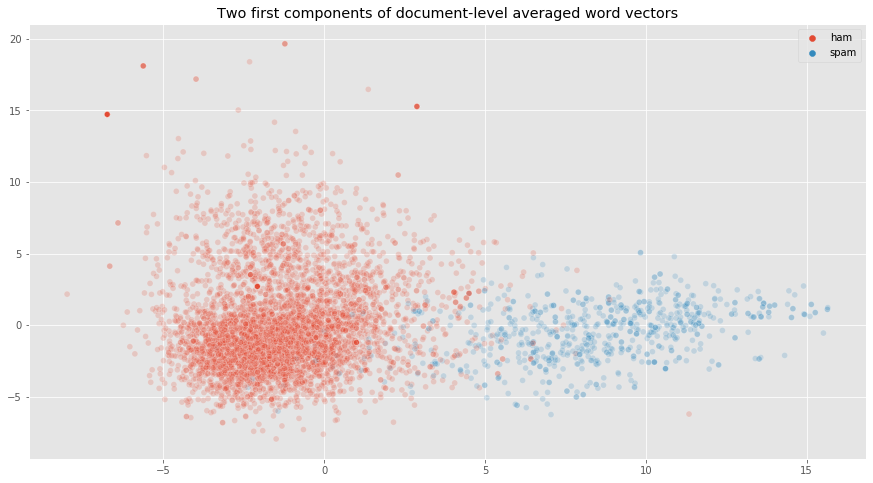

In [23]:
# Plot
plt.figure(figsize = (15, 8))
sns.scatterplot(X_train_2d[:, 0], 
                X_train_2d[:, 1], 
                hue = ['spam' if i == 1 else 'ham' for i in labels_clean], 
                alpha = .2)
plt.title('Two first components of document-level averaged word vectors')
plt.show()


#### Build a classifier

In [24]:
clf_01 = keras.Sequential([
    keras.layers.Dense(16, input_shape = (300,), activation = 'selu', kernel_initializer = 'lecun_normal'),
    keras.layers.AlphaDropout(.2),
    keras.layers.Dense(64, activation = 'selu', kernel_initializer = 'lecun_normal'),
    keras.layers.AlphaDropout(.2),
    keras.layers.Dense(32, activation = 'selu', kernel_initializer = 'lecun_normal'),
    keras.layers.AlphaDropout(.2),
    keras.layers.Dense(2, activation = 'sigmoid')
])

clf_01.compile(loss = keras.losses.SparseCategoricalCrossentropy(), 
               optimizer = keras.optimizers.RMSprop(learning_rate=.001),
               metrics = ['accuracy'])

In [25]:
clf_01.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                4816      
_________________________________________________________________
alpha_dropout (AlphaDropout) (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1088      
_________________________________________________________________
alpha_dropout_1 (AlphaDropou (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
alpha_dropout_2 (AlphaDropou (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 6

In [26]:
clf_01.fit(X_scaled, y_train, epochs = 50, verbose = 1)

Train on 5572 samples
Epoch 1/50
5572/5572 [==============================] - 2s 295us/sample - loss: 0.2846 - accuracy: 0.8609
Epoch 2/50
5572/5572 [==============================] - 0s 69us/sample - loss: 0.0967 - accuracy: 0.9646
Epoch 3/50
5572/5572 [==============================] - 0s 64us/sample - loss: 0.0650 - accuracy: 0.9788
Epoch 4/50
5572/5572 [==============================] - 0s 64us/sample - loss: 0.0590 - accuracy: 0.9817
Epoch 5/50
5572/5572 [==============================] - 0s 67us/sample - loss: 0.0541 - accuracy: 0.9831
Epoch 6/50
5572/5572 [==============================] - 0s 67us/sample - loss: 0.0482 - accuracy: 0.9844
Epoch 7/50
5572/5572 [==============================] - 0s 63us/sample - loss: 0.0478 - accuracy: 0.9840
Epoch 8/50
5572/5572 [==============================] - 0s 64us/sample - loss: 0.0444 - accuracy: 0.9874
Epoch 9/50
5572/5572 [==============================] - 1s 107us/sample - loss: 0.0399 - accuracy: 0.9880
Epoch 10/50
5572/5572 [========

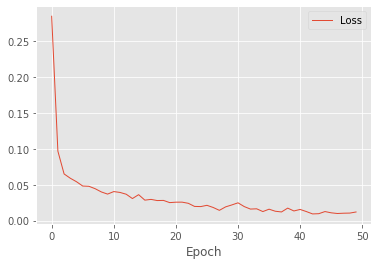

In [27]:
# Plot model loss
plt.plot(clf_01.history.history['loss'], label = 'Loss', lw = 1)
plt.legend()
plt.xlabel('Epoch')
plt.show()

In [28]:
for message, pred, label in zip(tokenized, clf_01.predict(X_scaled).argmax(axis = 1), y_train):
    if pred != label:
        print(f'{" ".join(message)[:80]:90}| Label: {int(label)} Pred: {pred}')

hi you just spoke to man ee sha v we'd like to know if you were satisfied with t          | Label: 0 Pred: 1
his b day real is in april                                                                | Label: 0 Pred: 1
hi you just spoke to man ee sha v we'd like to know if you were satisfied with t          | Label: 0 Pred: 1
hello darling how are you today i would love to have a chat why dont you tell me          | Label: 1 Pred: 0
how much it will cost approx per month                                                    | Label: 0 Pred: 1
ok but bag again                                                                          | Label: 0 Pred: 1


### Train pure `keras` model

We can also train embeddings simultaneously with the classifier using [Keras `Embedding` layer](https://keras.io/api/layers/core_layers/embedding/).

This layer learns embeddings specific for your supervised task. That's different from unsupervised (or self-supervised) approach used in pure Word2Vec. 

Both approaches might have advantages, depending on your task's context. E.g., [this paper](https://arxiv.org/abs/1804.06323) describes when using pre-trained vs learned embeddings can be beneficial.

Please note that the keras model that we train does not perform document-level averaging for embeddings. That's another difference comparing to our previous approach presented in ***Using gensim & keras*** section.

#### Preprocess the data

In [15]:
# Get maxlen 
MAX_LEN = max([len(row) for row in tokenized])

# Get vocab size
unique_words = []

for row in tokenized:
    for word in row:
        if word not in unique_words:
            unique_words.append(word)
          
VOCAB_SIZE = len(unique_words)

In [18]:
VOCAB_SIZE, MAX_LEN

(7510, 191)

In [28]:
# Define tokenizer
tokenizer = keras.preprocessing.text.Tokenizer(num_words = VOCAB_SIZE, filters = '')
tokenizer.fit_on_texts([' '.join(row) for row in tokenized])

sequences = tokenizer.texts_to_sequences([' '.join(row) for row in tokenized])
padded    = keras.preprocessing.sequence.pad_sequences(sequences, maxlen = MAX_LEN, padding='post') 

In [30]:
# Prepare y_train
y_train_02 = data.label.values.astype('float')

#### Define the model

In [31]:
clf_02 = keras.Sequential([
    keras.layers.Embedding(VOCAB_SIZE, 300, mask_zero = True, input_length = MAX_LEN),
    keras.layers.Flatten(),
    keras.layers.Dense(16, activation = 'selu', kernel_initializer = 'lecun_normal'),
    keras.layers.AlphaDropout(.2),
    keras.layers.Dense(64, activation = 'selu', kernel_initializer = 'lecun_normal'),
    keras.layers.AlphaDropout(.2),
    keras.layers.Dense(32, activation = 'selu', kernel_initializer = 'lecun_normal'),
    keras.layers.AlphaDropout(.2),
    keras.layers.Dense(2, activation = 'sigmoid')
])

clf_02.compile(loss = keras.losses.SparseCategoricalCrossentropy(), 
               optimizer = keras.optimizers.RMSprop(learning_rate=.001),
               metrics = ['accuracy'])

In [32]:
clf_02.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 191, 300)          2253000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 57300)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                916816    
_________________________________________________________________
alpha_dropout_3 (AlphaDropou (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                1088      
_________________________________________________________________
alpha_dropout_4 (AlphaDropou (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)               

In [33]:
clf_02.fit(padded, y_train_02, epochs = 15, verbose = 1)

Train on 4 samples
Epoch 1/15
4/4 [==============================] - 1s 301ms/sample - loss: 0.6544 - accuracy: 0.2500
Epoch 2/15
4/4 [==============================] - 0s 10ms/sample - loss: 0.1710 - accuracy: 1.0000
Epoch 3/15
4/4 [==============================] - 0s 12ms/sample - loss: 0.0113 - accuracy: 1.0000
Epoch 4/15
4/4 [==============================] - 0s 11ms/sample - loss: 0.0176 - accuracy: 1.0000
Epoch 5/15
4/4 [==============================] - 0s 10ms/sample - loss: 0.0826 - accuracy: 1.0000
Epoch 6/15
4/4 [==============================] - 0s 11ms/sample - loss: 0.0306 - accuracy: 1.0000
Epoch 7/15
4/4 [==============================] - 0s 10ms/sample - loss: 0.1394 - accuracy: 1.0000
Epoch 8/15
4/4 [==============================] - 0s 11ms/sample - loss: 0.0921 - accuracy: 1.0000
Epoch 9/15
4/4 [==============================] - 0s 10ms/sample - loss: 0.1315 - accuracy: 1.0000
Epoch 10/15
4/4 [==============================] - 0s 12ms/sample - loss: 5.7127e-05 - ac

In [34]:
# Plot model loss
plt.plot(clf_01.history.history['loss'], label = 'Loss clf_01', lw = 1)
plt.plot(clf_02.history.history['loss'], label = 'Loss clf_02', lw = 1)
plt.legend()
plt.xlabel('Epoch')
plt.show()

NameError: name 'clf_01' is not defined

In [41]:
for message, pred, label in zip(tokenized, clf_02.predict(padded).argmax(axis = 1), y_train_02):
    if pred != label:
        print(f'{" ".join(message)[:80]:90}| Label: {int(label)} Pred: {pred}')